by-latitude quantities - also extraction of monthly data

In [32]:
import xarray as xr
import glob
import numpy as np
import netCDF4 as nc
import warnings
import matplotlib.path as mpath
import cartopy.feature as cfeature

warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from cmocean import cm
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/')
import scendict as sc
import utils as ut

In [33]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# Exploring SO carbon sink and other related factors by latitude

### background
We are trying to understand the relative effect of GHG scenario (SSP1 vs SSP3) and ozone scenario (No ozone hole, ozone hole happens and recovers,
ozone hole continues forever) on southern ocean carbon cycling (and the sink strength of the SO), via 6 runsets that span the scenario space above. 

1) We know that there are measurable historical and future changes in the windspeed, especially in summer,
between different 6 different ozone/ GHG scenarios, see slide 15 here:
https://tjarnikova.github.io/pres/2022JUL_CELOS.html#15

2) Winds are very important to the air-sea co2 pathways and overall sink strength. 
Yet, we are struggling to see a good response signal in the air-sea co2 flux & therefore sink strength between ozone scenarios for a given GHG scenario. 
Instead what seems to happen is that there is a big difference in source strength between SSPs (GHG scenarios) but not between ozone scenarios. See first picture here:
https://nbviewer.org/github/tjarnikova/SOZONE/blob/master/MODPROC_ROBOT/MultiModelMonitor/UnspunupFullRunsetSummary.ipynb

3) From 1) we know that the wind speed increases mostly occurred in the summer, historically. From 2) we know that the wind increases are sorta limited to certain latitude bands (last picture here, bands 3-5, band 0 starts at bottom (southernmost)): 
https://nbviewer.org/github/tjarnikova/SOZONE/blob/master/windAnalyis/LatitudinalWinds.ipynb

So, here we will subdivide the sink into different latitude bands and look at different drivers/ related parameters in different seasons and see if we can see a signal, any signal...

Here are the latitudinal bands I've decided to work with:

In [34]:
def plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, northex = -50, fs = 12, 
                  tit = '', cbarlab = '', tcmap = 'viridis', lm = True, cbr = True):
   
    ax1.set_extent([-180, 180, -80, -25], ccrs.PlateCarree())
    #make that circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)
    lons = nav_lon[0:50,:]; lats = nav_lat[0:50,:]; 
    mesh = ax1.pcolormesh(lons, lats, tdat, cmap = tcmap, vmin = tvmin, vmax = tvmax, 
                     transform=ccrs.PlateCarree())
    
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                 edgecolor='face', facecolor='k'))
    ax1.set_title(tit, fontsize = fs)
    cb = 0
    if cbr:
        cb = fig.colorbar(mesh, ax = ax1, orientation = 'horizontal',
                     pad = 0.06, fraction = 0.045, shrink = 0.9)
        cb.set_label(label=cbarlab,fontsize = fs)
        cb.set_ticks(tticks, fontsize = 105)
        cb.ax.tick_params(labelsize=16)
    return cb

In [35]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
csize = tmesh['csize'].values

bounds = np.array([0,7,16,22,28,32,37,40,44,47,50])
starts = np.zeros([10]); ends = np.zeros([10])
print(' latitude bands:')
for i in range(0,len(bounds)-1):
    s= np.format_float_positional(tmesh['nav_lat'][bounds[i],0].values, precision=1)
    e= np.format_float_positional(tmesh['nav_lat'][bounds[i+1],0].values, precision=1)
    print(f'band {i}, {(s)} to {e}, indexes ({bounds[i]}-{bounds[i+1]})' )
    starts[i] = s
    ends[i] = e

 latitude bands:
band 0, -78.2 to -75., indexes (0-7)
band 1, -75. to -69.5, indexes (7-16)
band 2, -69.5 to -64.9, indexes (16-22)
band 3, -64.9 to -59.3, indexes (22-28)
band 4, -59.3 to -54.9, indexes (28-32)
band 5, -54.9 to -48.8, indexes (32-37)
band 6, -48.8 to -44.6, indexes (37-40)
band 7, -44.6 to -38.7, indexes (40-44)
band 8, -38.7 to -33.8, indexes (44-47)
band 9, -33.8 to -28.7, indexes (47-50)


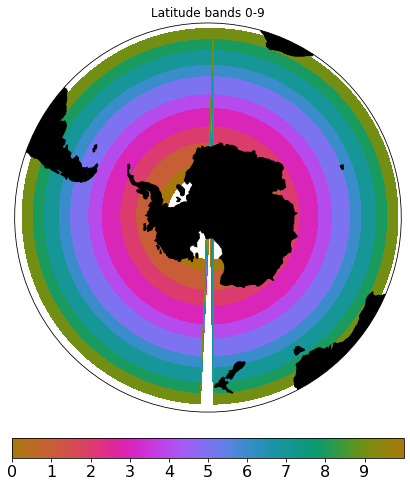

In [36]:
basin = nc.Dataset('/gpfs/data/greenocean/software/resources/ModelResources/BasinMasks/clq_basin_masks_ORCA.nc')
nav_lat = basin['Y'][:]
nav_lon = basin['X'][:]

lons = nav_lon[0:50,:]
lats = nav_lat[0:50,:]

tdat = np.zeros_like(lats)


for i in range(0,len(bounds)-1):
    tdat[bounds[i]:bounds[i+1],:] = i


tvmin = 0;tvmax = 10

fact = 0.4
ticks = np.arange(0,10,1); tfs = 12

tfig = plt.figure(figsize=[20*fact, 20*fact])
ax1 = tfig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, -90))

cb = plot_southern(tfig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, ticks, northex = -35, fs = tfs,
                  tit = 'Latitude bands 0-9', cbarlab = '', tcmap = cm.phase, lm = True, cbr = True)


saved an intermediate product of cflx for the 6 run sets

In [37]:
## extract timeseries 
exhorse = False

dsets  = ['TOM12_TJ_1ASA','TOM12_TJ_1BSA', 'TOM12_TJ_3ASA', 'TOM12_TJ_3BSA',\
          'TOM12_TJ_2ASA', 'TOM12_TJ_2BSA']
if exhorse:
    
    for d in dsets:
        print(d)
        ylist = ut.make_yearlist(1948,2100,'diad_T',d)
        with xr.set_options(enable_cftimeindex=True):
            TJ_1ASA = xr.open_mfdataset(ylist)
        TJ_1ASA['time_counter'] = TJ_1ASA.indexes['time_counter'].to_datetimeindex()
        #extract the relevant
        nav_lat = TJ_1ASA['nav_lat'][:,0].values
        nav_lon = TJ_1ASA['nav_lon'][0,:].values
        time_counter = TJ_1ASA['time_counter'].values
        Cflx = TJ_1ASA['Cflx'].values
        
        # define data with variable attributes
        data_vars = {'cflx':(['time_counter','nav_lat','nav_lon'], Cflx, 
                                 {'units': 'mol m-2 s-1', 
                                  'long_name':'free-fall velocity'})}

        # define coordinates
        coords = {'time_counter': (['time_counter'], time_counter),\
                 'nav_lat': (['nav_lat'], nav_lat),\
                 'nav_lon': (['nav_lon'], nav_lon)}

        # define global attributes
        attrs = {'author':'TJSJ', 
                 'email':'address@email.com'}

        # create dataset
        ds = xr.Dataset(data_vars=data_vars, 
                        coords=coords, 
                        attrs=attrs)
        
        tdir = '/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs/'
        fn = f'{tdir}/{d}_cflx_fullts.nc'
        ds.to_netcdf(fn)

In [38]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs/'
cflx_1ASA = xr.open_dataset(f'{tdir}TOM12_TJ_1ASA_cflx_fullts.nc')
cflx_1BSA = xr.open_dataset(f'{tdir}TOM12_TJ_1BSA_cflx_fullts.nc')
cflx_2ASA = xr.open_dataset(f'{tdir}TOM12_TJ_2ASA_cflx_fullts.nc')
cflx_2BSA = xr.open_dataset(f'{tdir}TOM12_TJ_2BSA_cflx_fullts.nc')
cflx_3ASA = xr.open_dataset(f'{tdir}TOM12_TJ_3ASA_cflx_fullts.nc')
cflx_3BSA = xr.open_dataset(f'{tdir}TOM12_TJ_3BSA_cflx_fullts.nc')




made by-latitudeband averages at monthly (ie model) resolution

In [39]:
cflx_1ASA_blyat = np.zeros([1836,10])
for i in range(0,1836):
    tv = cflx_1ASA['cflx'].values
    for b in range(0,10):
        cflx_1ASA_blyat[i,b] = np.average(tv[i,bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        
cflx_1BSA_blyat = np.zeros([1836,10])
for i in range(0,1836):
    tv = cflx_1BSA['cflx'].values
    for b in range(0,10):
        cflx_1BSA_blyat[i,b] = np.average(tv[i,bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        
cflx_2ASA_blyat = np.zeros([1836,10])
for i in range(0,1836):
    tv = cflx_2ASA['cflx'].values
    for b in range(0,10):
        cflx_2ASA_blyat[i,b] = np.average(tv[i,bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        
cflx_2BSA_blyat = np.zeros([1836,10])
for i in range(0,1836):
    tv = cflx_2BSA['cflx'].values
    for b in range(0,10):
        cflx_2BSA_blyat[i,b] = np.average(tv[i,bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        
cflx_3ASA_blyat = np.zeros([1836,10])
for i in range(0,1836):
    tv = cflx_3ASA['cflx'].values
    for b in range(0,10):
        cflx_3ASA_blyat[i,b] = np.average(tv[i,bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        
cflx_3BSA_blyat = np.zeros([1836,10])
for i in range(0,1836):
    tv = cflx_3BSA['cflx'].values
    for b in range(0,10):
        cflx_3BSA_blyat[i,b] = np.average(tv[i,bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        


### Fig A: Here is the raw data - cflx for all 6 scenarios by latitude band:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.9, 'latitude-band area-weighted air-sea co2 flux (positive is sink-into-ocean), mol/m2/s, monthly resolution')

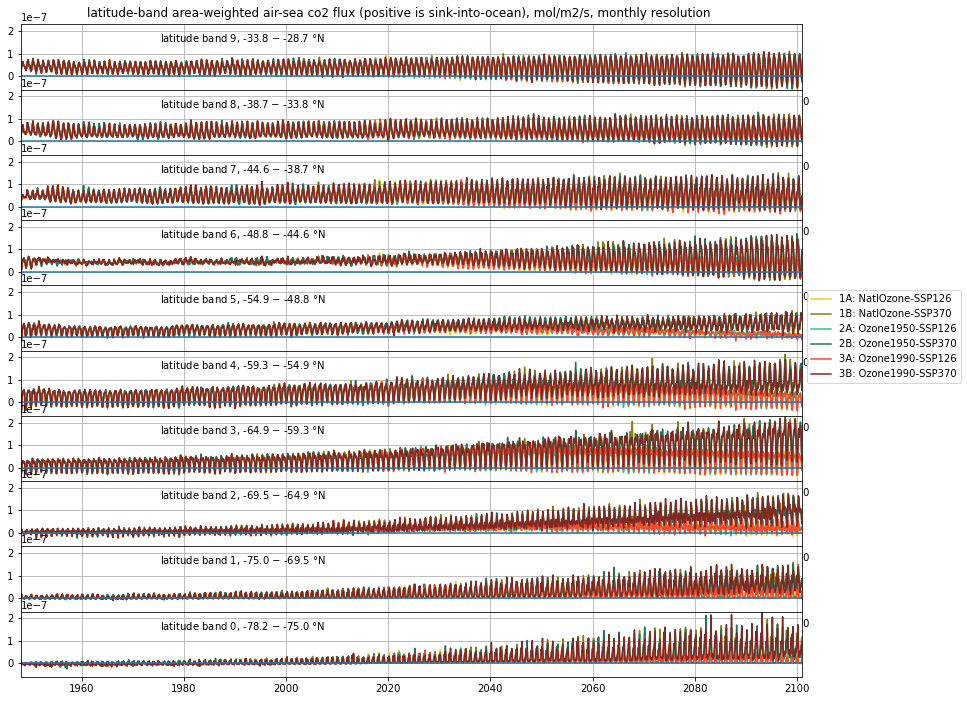

In [40]:
blyats = [cflx_1ASA_blyat, cflx_1BSA_blyat, cflx_2ASA_blyat, cflx_2BSA_blyat, cflx_3ASA_blyat, cflx_3BSA_blyat]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']

fact = 0.45
fig, axs = plt.subplots(10,1, figsize=(14, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(0,10):
    pos = 9-i
    for s in range(0,6):
        tb = blyats[s]
        axs[i].plot(cflx_1ASA['time_counter'].values,tb[:,pos], alpha = 1, color = sc.scen[scens[s]]['color'], label = sc.scen[scens[s]]['name2'])

    axs[4].legend(bbox_to_anchor = [1,1])
    axs[i].text(1930,1.5e-7,f'latitude band {pos}, {starts[pos]} $-$ {ends[pos]} $\degree$N')
    axs[i].set_ylim([-0.6e-7,2.3e-7])
    st = cflx_1ASA['time_counter'].values[0]
    en = cflx_1ASA['time_counter'].values[1835]
    axs[i].set_xlim([st,en])
    axs[i].grid()
    axs[i].axhline(y=0)
    
plt.suptitle('latitude-band area-weighted air-sea co2 flux (positive is sink-into-ocean), mol/m2/s, monthly resolution', y = 0.9)

Main points:

- can't see all 6 scenarios, but they do not seem to differ hugely at first glance - needs more digging
- band 2,3, 4, 5, have biggest changes in sink strength at first glance
- massive changes in amplitude of seasonal cycle! 

### Fig B) extract monthly winds to compare in a similar way:

In [41]:
scen = '1A'; tw = f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_{scen}_monthly_wspd.nc'
w = xr.open_dataset(tw)
wind_1ASA_blyat = np.zeros([1836,10])
ind = 0
for tyr in range(1948,2101):
    for tmo in range(1,13):
        tv= w.mean_wspd.sel(yr=tyr, mon = tmo, method='nearest').values
        for b in range(0,10):
            wind_1ASA_blyat[ind,b] = np.average(tv[bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        ind = ind+1

scen = '1B'; tw = f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_{scen}_monthly_wspd.nc'
w = xr.open_dataset(tw)
wind_1BSA_blyat = np.zeros([1836,10])
ind = 0
for tyr in range(1948,2101):
    for tmo in range(1,13):
        tv= w.mean_wspd.sel(yr=tyr, mon = tmo, method='nearest').values
        for b in range(0,10):
            wind_1BSA_blyat[ind,b] = np.average(tv[bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        ind = ind+1

scen = '2A'; tw = f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_{scen}_monthly_wspd.nc'
w = xr.open_dataset(tw)
wind_2ASA_blyat = np.zeros([1836,10])
ind = 0
for tyr in range(1948,2101):
    for tmo in range(1,13):
        tv= w.mean_wspd.sel(yr=tyr, mon = tmo, method='nearest').values
        for b in range(0,10):
            wind_2ASA_blyat[ind,b] = np.average(tv[bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        ind = ind+1

scen = '2B'; tw = f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_{scen}_monthly_wspd.nc'
w = xr.open_dataset(tw)
wind_2BSA_blyat = np.zeros([1836,10])
ind = 0
for tyr in range(1948,2101):
    for tmo in range(1,13):
        tv= w.mean_wspd.sel(yr=tyr, mon = tmo, method='nearest').values
        for b in range(0,10):
            wind_2BSA_blyat[ind,b] = np.average(tv[bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        ind = ind+1

scen = '3A'; tw = f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_{scen}_monthly_wspd.nc'
w = xr.open_dataset(tw)
wind_3ASA_blyat = np.zeros([1836,10])
ind = 0
for tyr in range(1948,2101):
    for tmo in range(1,13):
        tv= w.mean_wspd.sel(yr=tyr, mon = tmo, method='nearest').values
        for b in range(0,10):
            wind_3ASA_blyat[ind,b] = np.average(tv[bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        ind = ind+1

scen = '3B'; tw = f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_{scen}_monthly_wspd.nc'
w = xr.open_dataset(tw)
wind_3BSA_blyat = np.zeros([1836,10])
ind = 0
for tyr in range(1948,2101):
    for tmo in range(1,13):
        tv= w.mean_wspd.sel(yr=tyr, mon = tmo, method='nearest').values
        for b in range(0,10):
            wind_3BSA_blyat[ind,b] = np.average(tv[bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        ind = ind+1
        


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.9, 'latitude-band area-weighted monthly windspeed, monthly resolution')

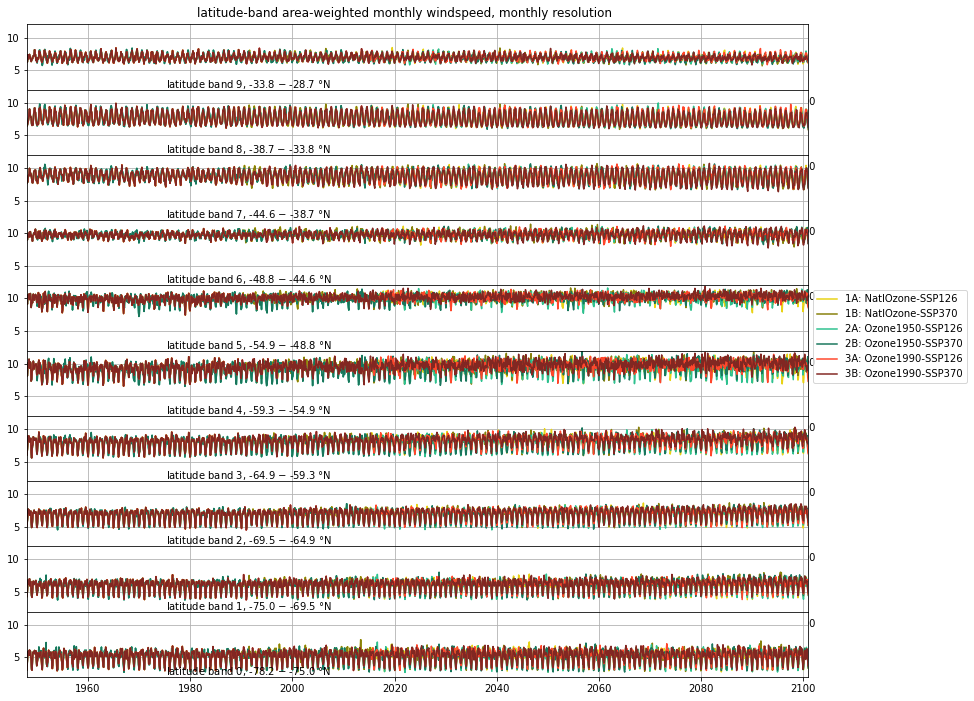

In [42]:
blyats = [wind_1ASA_blyat, wind_1BSA_blyat, wind_2ASA_blyat, wind_2BSA_blyat, wind_3ASA_blyat, wind_3BSA_blyat]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']

fact = 0.45
fig, axs = plt.subplots(10,1, figsize=(14, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(0,10):
    pos = 9-i
    for s in range(0,6):
        tb = blyats[s]
        axs[i].plot(cflx_1ASA['time_counter'].values,tb[:,pos], alpha = 1, color = sc.scen[scens[s]]['color'], label = sc.scen[scens[s]]['name2'])

    axs[4].legend(bbox_to_anchor = [1,1])
    axs[i].text(1930,2.3,f'latitude band {pos}, {starts[pos]} $-$ {ends[pos]} $\degree$N')
    axs[i].set_ylim([2,12])
    st = cflx_1ASA['time_counter'].values[0]
    en = cflx_1ASA['time_counter'].values[1835]
    axs[i].set_xlim([st,en])
    axs[i].grid()
plt.suptitle('latitude-band area-weighted monthly windspeed, monthly resolution', y = 0.9)



In [43]:
print(np.shape(wind_1ASA_blyat))

(1836, 10)


In [44]:
months = cflx_1ASA['time_counter'].dt.month.values
yrs = cflx_1ASA['time_counter'].dt.year.values

myrs = np.arange(1948,2101,1)
wind_summer_1ASA = np.zeros([10,153])
cflx_summer_1ASA = np.zeros([10,153])
wind_summer_1BSA = np.zeros([10,153])
cflx_summer_1BSA = np.zeros([10,153])
wind_summer_2ASA = np.zeros([10,153])
cflx_summer_2ASA = np.zeros([10,153])
wind_summer_2BSA = np.zeros([10,153])
cflx_summer_2BSA = np.zeros([10,153])
wind_summer_3ASA = np.zeros([10,153])
cflx_summer_3ASA = np.zeros([10,153])
wind_summer_3BSA = np.zeros([10,153])
cflx_summer_3BSA = np.zeros([10,153])

for i in range(0,153):
    tyr = myrs[i]
    wind_summer_1ASA[:,i] = ((wind_1ASA_blyat[(months == 12) & (yrs == tyr)] * 31 +
    wind_1ASA_blyat[(months == 1) & (yrs == tyr)] * 31 + 
    wind_1ASA_blyat[(months == 2) & (yrs == tyr)] * 28)/(31+31+28))
    cflx_summer_1ASA[:,i] = ((cflx_1ASA_blyat[(months == 12) & (yrs == tyr)] * 31 +
    cflx_1ASA_blyat[(months == 1) & (yrs == tyr)] * 31 + 
    cflx_1ASA_blyat[(months == 2) & (yrs == tyr)] * 28)/(31+31+28))
    
    wind_summer_1BSA[:,i] = ((wind_1BSA_blyat[(months == 12) & (yrs == tyr)] * 31 +
    wind_1BSA_blyat[(months == 1) & (yrs == tyr)] * 31 + 
    wind_1BSA_blyat[(months == 2) & (yrs == tyr)] * 28)/(31+31+28))
    cflx_summer_1BSA[:,i] = ((cflx_1BSA_blyat[(months == 12) & (yrs == tyr)] * 31 +
    cflx_1BSA_blyat[(months == 1) & (yrs == tyr)] * 31 + 
    cflx_1BSA_blyat[(months == 2) & (yrs == tyr)] * 28)/(31+31+28))
    wind_summer_2ASA[:,i] = ((wind_2ASA_blyat[(months == 12) & (yrs == tyr)] * 31 +
    wind_2ASA_blyat[(months == 1) & (yrs == tyr)] * 31 + 
    wind_2ASA_blyat[(months == 2) & (yrs == tyr)] * 28)/(31+31+28))
    cflx_summer_2ASA[:,i] = ((cflx_2ASA_blyat[(months == 12) & (yrs == tyr)] * 31 +
    cflx_2ASA_blyat[(months == 1) & (yrs == tyr)] * 31 + 
    cflx_2ASA_blyat[(months == 2) & (yrs == tyr)] * 28)/(31+31+28))
    wind_summer_2BSA[:,i] = ((wind_2BSA_blyat[(months == 12) & (yrs == tyr)] * 31 +
    wind_2BSA_blyat[(months == 1) & (yrs == tyr)] * 31 + 
    wind_2BSA_blyat[(months == 2) & (yrs == tyr)] * 28)/(31+31+28))
    cflx_summer_2BSA[:,i] = ((cflx_2BSA_blyat[(months == 12) & (yrs == tyr)] * 31 +
    cflx_2BSA_blyat[(months == 1) & (yrs == tyr)] * 31 + 
    cflx_2BSA_blyat[(months == 2) & (yrs == tyr)] * 28)/(31+31+28))
    wind_summer_3ASA[:,i] = ((wind_3ASA_blyat[(months == 12) & (yrs == tyr)] * 31 +
    wind_3ASA_blyat[(months == 1) & (yrs == tyr)] * 31 + 
    wind_3ASA_blyat[(months == 2) & (yrs == tyr)] * 28)/(31+31+28))
    cflx_summer_3ASA[:,i] = ((cflx_3ASA_blyat[(months == 12) & (yrs == tyr)] * 31 +
    cflx_3ASA_blyat[(months == 1) & (yrs == tyr)] * 31 + 
    cflx_3ASA_blyat[(months == 2) & (yrs == tyr)] * 28)/(31+31+28))
    wind_summer_3BSA[:,i] = ((wind_3BSA_blyat[(months == 12) & (yrs == tyr)] * 31 +
    wind_3BSA_blyat[(months == 1) & (yrs == tyr)] * 31 + 
    wind_3BSA_blyat[(months == 2) & (yrs == tyr)] * 28)/(31+31+28))
    cflx_summer_3BSA[:,i] = ((cflx_3BSA_blyat[(months == 12) & (yrs == tyr)] * 31 +
    cflx_3BSA_blyat[(months == 1) & (yrs == tyr)] * 31 + 
    cflx_3BSA_blyat[(months == 2) & (yrs == tyr)] * 28)/(31+31+28))

In [45]:
months = cflx_1ASA['time_counter'].dt.month.values
yrs = cflx_1ASA['time_counter'].dt.year.values

myrs = np.arange(1948,2101,1)
wind_winter_1ASA = np.zeros([10,153])
cflx_winter_1ASA = np.zeros([10,153])
wind_winter_1BSA = np.zeros([10,153])
cflx_winter_1BSA = np.zeros([10,153])
wind_winter_2ASA = np.zeros([10,153])
cflx_winter_2ASA = np.zeros([10,153])
wind_winter_2BSA = np.zeros([10,153])
cflx_winter_2BSA = np.zeros([10,153])
wind_winter_3ASA = np.zeros([10,153])
cflx_winter_3ASA = np.zeros([10,153])
wind_winter_3BSA = np.zeros([10,153])
cflx_winter_3BSA = np.zeros([10,153])

for i in range(0,153):
    tyr = myrs[i]
    wind_winter_1ASA[:,i] = ((wind_1ASA_blyat[(months == 6) & (yrs == tyr)] * 30 +
    wind_1ASA_blyat[(months == 7) & (yrs == tyr)] * 31 + 
    wind_1ASA_blyat[(months == 8) & (yrs == tyr)] * 31)/(31+31+30))
    cflx_winter_1ASA[:,i] = ((cflx_1ASA_blyat[(months == 6) & (yrs == tyr)] * 30 +
    cflx_1ASA_blyat[(months == 7) & (yrs == tyr)] * 31 + 
    cflx_1ASA_blyat[(months == 8) & (yrs == tyr)] * 31)/(31+31+30))
    
    wind_winter_1BSA[:,i] = ((wind_1BSA_blyat[(months == 6) & (yrs == tyr)] * 30 +
    wind_1BSA_blyat[(months == 7) & (yrs == tyr)] * 31 + 
    wind_1BSA_blyat[(months == 8) & (yrs == tyr)] * 31)/(31+31+30))
    cflx_winter_1BSA[:,i] = ((cflx_1BSA_blyat[(months == 6) & (yrs == tyr)] * 30 +
    cflx_1BSA_blyat[(months == 7) & (yrs == tyr)] * 31 + 
    cflx_1BSA_blyat[(months == 8) & (yrs == tyr)] * 31)/(31+31+30))
    wind_winter_2ASA[:,i] = ((wind_2ASA_blyat[(months == 6) & (yrs == tyr)] * 30 +
    wind_2ASA_blyat[(months == 7) & (yrs == tyr)] * 31 + 
    wind_2ASA_blyat[(months == 8) & (yrs == tyr)] * 31)/(31+31+30))
    cflx_winter_2ASA[:,i] = ((cflx_2ASA_blyat[(months == 6) & (yrs == tyr)] * 30 +
    cflx_2ASA_blyat[(months == 7) & (yrs == tyr)] * 31 + 
    cflx_2ASA_blyat[(months == 8) & (yrs == tyr)] * 31)/(31+31+30))
    wind_winter_2BSA[:,i] = ((wind_2BSA_blyat[(months == 6) & (yrs == tyr)] * 30 +
    wind_2BSA_blyat[(months == 7) & (yrs == tyr)] * 31 + 
    wind_2BSA_blyat[(months == 8) & (yrs == tyr)] * 31)/(31+31+30))
    cflx_winter_2BSA[:,i] = ((cflx_2BSA_blyat[(months == 6) & (yrs == tyr)] * 30 +
    cflx_2BSA_blyat[(months == 7) & (yrs == tyr)] * 31 + 
    cflx_2BSA_blyat[(months == 8) & (yrs == tyr)] * 31)/(31+31+30))
    wind_winter_3ASA[:,i] = ((wind_3ASA_blyat[(months == 6) & (yrs == tyr)] * 30 +
    wind_3ASA_blyat[(months == 7) & (yrs == tyr)] * 31 + 
    wind_3ASA_blyat[(months == 8) & (yrs == tyr)] * 31)/(31+31+30))
    cflx_winter_3ASA[:,i] = ((cflx_3ASA_blyat[(months == 6) & (yrs == tyr)] * 30 +
    cflx_3ASA_blyat[(months == 7) & (yrs == tyr)] * 31 + 
    cflx_3ASA_blyat[(months == 8) & (yrs == tyr)] * 31)/(31+31+30))
    wind_winter_3BSA[:,i] = ((wind_3BSA_blyat[(months == 6) & (yrs == tyr)] * 30 +
    wind_3BSA_blyat[(months == 7) & (yrs == tyr)] * 31 + 
    wind_3BSA_blyat[(months == 8) & (yrs == tyr)] * 31)/(31+31+30))
    cflx_winter_3BSA[:,i] = ((cflx_3BSA_blyat[(months == 6) & (yrs == tyr)] * 30 +
    cflx_3BSA_blyat[(months == 7) & (yrs == tyr)] * 31 + 
    cflx_3BSA_blyat[(months == 8) & (yrs == tyr)] * 31)/(31+31+30))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1, 'latitude-band area-weighted summer cflx, yearly resolution, mol/m2/s, positive is sink-into-ocean')

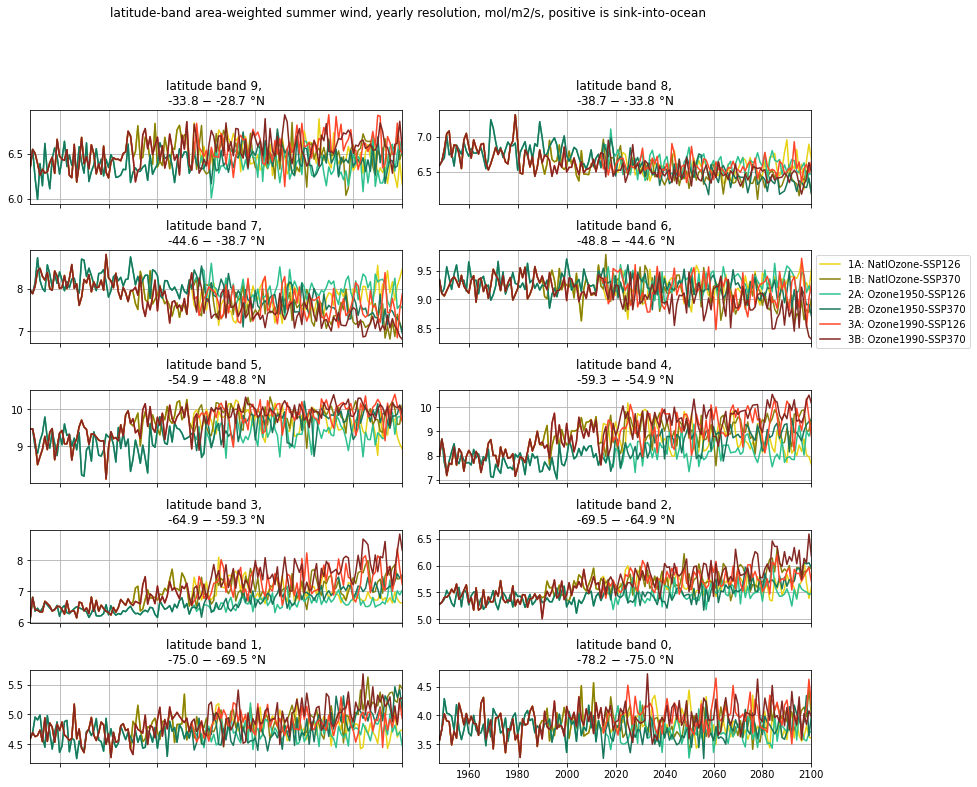

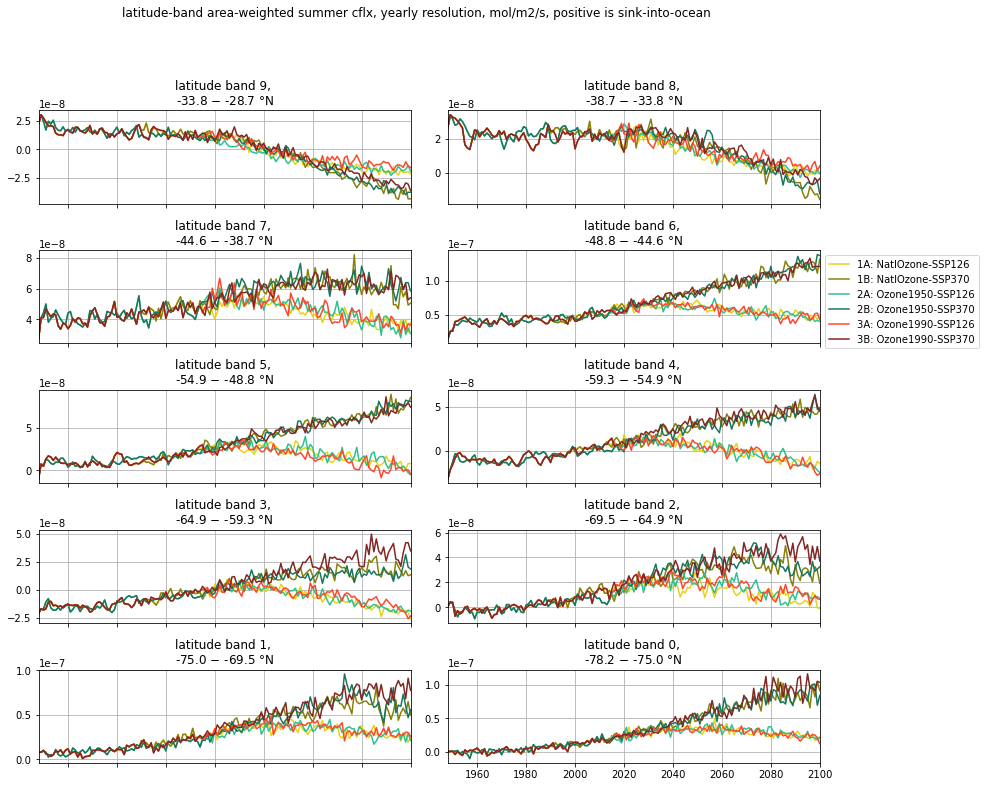

In [46]:
wind_sum = [wind_summer_1ASA, wind_summer_1BSA, wind_summer_2ASA, wind_summer_2BSA, wind_summer_3ASA, wind_summer_3BSA]

scens = ['1A', '1B', '2A', '2B', '3A', '3B']

fact = 0.45
fig, axs = plt.subplots(5,2, figsize=(14, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(wspace=0.1, hspace=0.5)
for i in range(0,10):
    pos = 9-i
    for s in range(0,6):
        tb = wind_sum[s]
        axs[i].plot(myrs,tb[pos,:], alpha = 1, color = sc.scen[scens[s]]['color'], label = sc.scen[scens[s]]['name2'], linestyle = '-')
        # tb = wind_win[s]
        # axs[i].plot(myrs,tb[pos,:], alpha = 1, color = sc.scen[scens[s]]['color'], label = sc.scen[scens[s]]['name2'], linestyle = '-')

    axs[3].legend(bbox_to_anchor = [1,1])
    axs[i].set_title(f'latitude band {pos}, \n{starts[pos]} $-$ {ends[pos]} $\degree$N')
    #axs[i].set_ylim([5,12])
    # st = wind_1ASA['time_counter'].values[0]
    # en = wind_1ASA['time_counter'].values[1835]
    axs[i].set_xlim([1948,2100])
    if i!= 9:
        axs[i].set_xticklabels([])
    axs[i].grid()
    #axs[i].axhline(y=0)
plt.suptitle('latitude-band area-weighted summer wind, yearly resolution, mol/m2/s, positive is sink-into-ocean', y = 1)

cflx_sum = [cflx_summer_1ASA, cflx_summer_1BSA, cflx_summer_2ASA, cflx_summer_2BSA, cflx_summer_3ASA, cflx_summer_3BSA]

scens = ['1A', '1B', '2A', '2B', '3A', '3B']

fact = 0.45
fig, axs = plt.subplots(5,2, figsize=(14, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(wspace=0.1, hspace=0.5)
for i in range(0,10):
    pos = 9-i
    for s in range(0,6):
        tb = cflx_sum[s]
        axs[i].plot(myrs,tb[pos,:], alpha = 1, color = sc.scen[scens[s]]['color'], label = sc.scen[scens[s]]['name2'], linestyle = '-')
        # tb = cflx_win[s]
        # axs[i].plot(myrs,tb[pos,:], alpha = 1, color = sc.scen[scens[s]]['color'], label = sc.scen[scens[s]]['name2'], linestyle = '-')

    axs[3].legend(bbox_to_anchor = [1,1])
    axs[i].set_title(f'latitude band {pos}, \n{starts[pos]} $-$ {ends[pos]} $\degree$N')
    #axs[i].set_ylim([5,12])
    # st = cflx_1ASA['time_counter'].values[0]
    # en = cflx_1ASA['time_counter'].values[1835]
    axs[i].set_xlim([1948,2100])
    if i!= 9:
        axs[i].set_xticklabels([])
    axs[i].grid()
    #axs[i].axhline(y=0)
plt.suptitle('latitude-band area-weighted summer cflx, yearly resolution, mol/m2/s, positive is sink-into-ocean', y = 1)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1, 'latitude-band area-weighted winter cflx, yearly resolution, mol/m2/s, positive is sink-into-ocean')

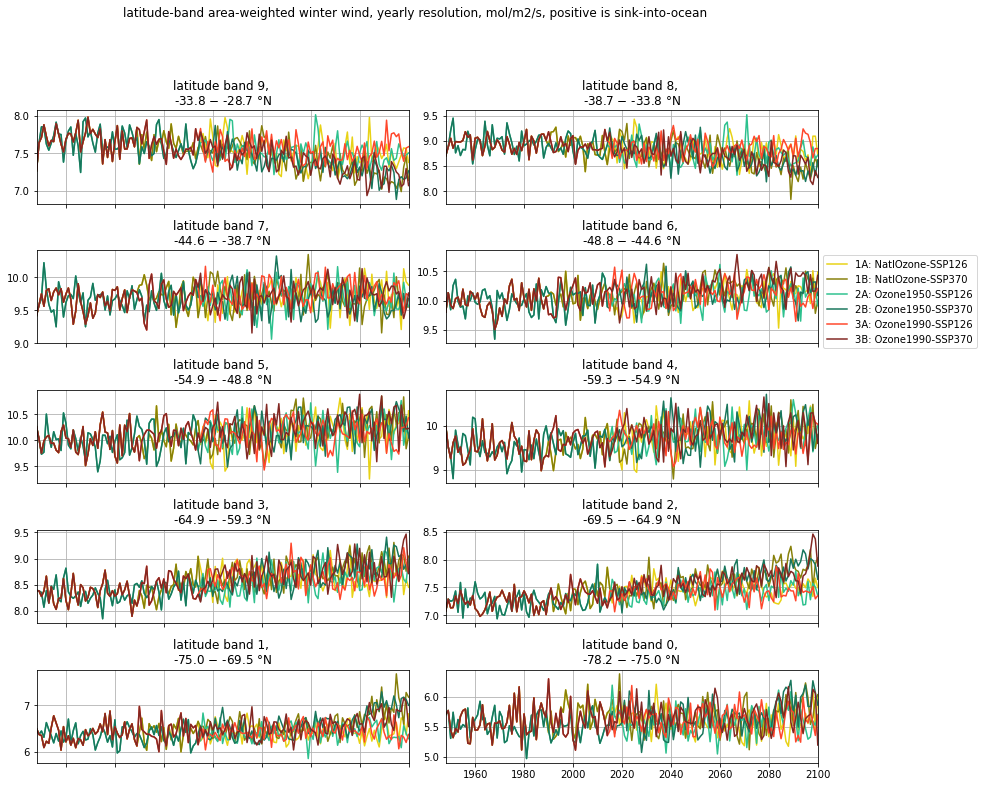

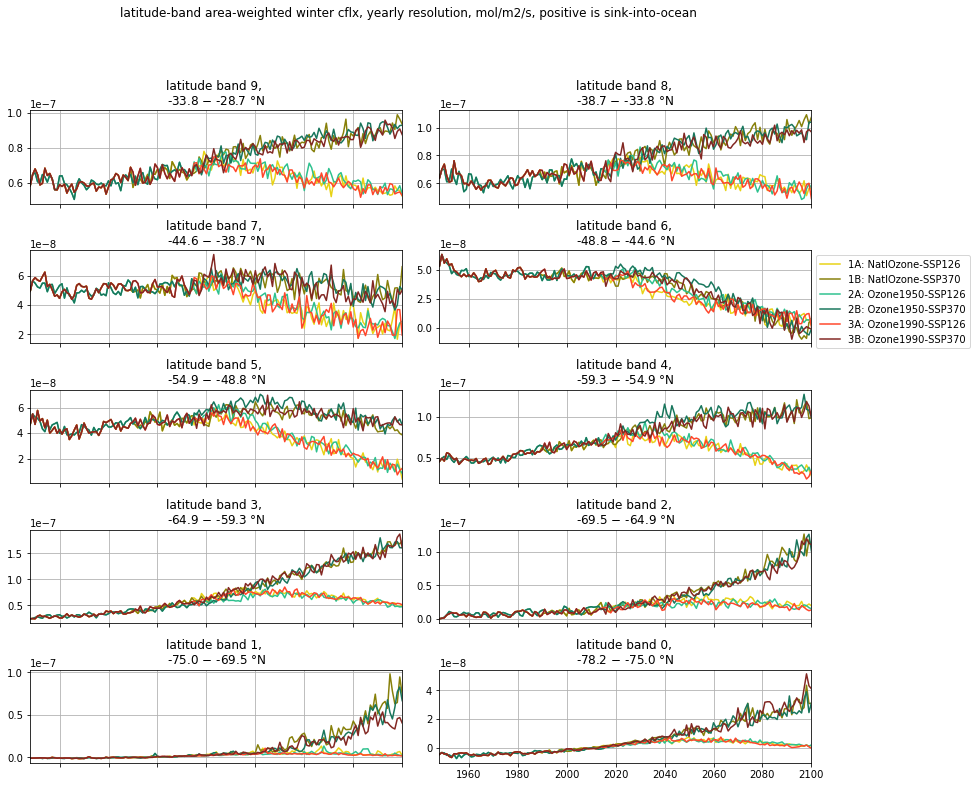

In [47]:
wind_sum = [wind_winter_1ASA, wind_winter_1BSA, wind_winter_2ASA, wind_winter_2BSA, wind_winter_3ASA, wind_winter_3BSA]

scens = ['1A', '1B', '2A', '2B', '3A', '3B']

fact = 0.45
fig, axs = plt.subplots(5,2, figsize=(14, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(wspace=0.1, hspace=0.5)
for i in range(0,10):
    pos = 9-i
    for s in range(0,6):
        tb = wind_sum[s]
        axs[i].plot(myrs,tb[pos,:], alpha = 1, color = sc.scen[scens[s]]['color'], label = sc.scen[scens[s]]['name2'], linestyle = '-')
        # tb = wind_win[s]
        # axs[i].plot(myrs,tb[pos,:], alpha = 1, color = sc.scen[scens[s]]['color'], label = sc.scen[scens[s]]['name2'], linestyle = '-')

    axs[3].legend(bbox_to_anchor = [1,1])
    axs[i].set_title(f'latitude band {pos}, \n{starts[pos]} $-$ {ends[pos]} $\degree$N')
    #axs[i].set_ylim([5,12])
    # st = wind_1ASA['time_counter'].values[0]
    # en = wind_1ASA['time_counter'].values[1835]
    axs[i].set_xlim([1948,2100])
    if i!= 9:
        axs[i].set_xticklabels([])
    axs[i].grid()
    #axs[i].axhline(y=0)
plt.suptitle('latitude-band area-weighted winter wind, yearly resolution, mol/m2/s, positive is sink-into-ocean', y = 1)

cflx_sum = [cflx_winter_1ASA, cflx_winter_1BSA, cflx_winter_2ASA, cflx_winter_2BSA, cflx_winter_3ASA, cflx_winter_3BSA]

scens = ['1A', '1B', '2A', '2B', '3A', '3B']

fact = 0.45
fig, axs = plt.subplots(5,2, figsize=(14, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(wspace=0.1, hspace=0.5)
for i in range(0,10):
    pos = 9-i
    for s in range(0,6):
        tb = cflx_sum[s]
        axs[i].plot(myrs,tb[pos,:], alpha = 1, color = sc.scen[scens[s]]['color'], label = sc.scen[scens[s]]['name2'], linestyle = '-')
        # tb = cflx_win[s]
        # axs[i].plot(myrs,tb[pos,:], alpha = 1, color = sc.scen[scens[s]]['color'], label = sc.scen[scens[s]]['name2'], linestyle = '-')

    axs[3].legend(bbox_to_anchor = [1,1])
    axs[i].set_title(f'latitude band {pos}, \n{starts[pos]} $-$ {ends[pos]} $\degree$N')
    #axs[i].set_ylim([5,12])
    # st = cflx_1ASA['time_counter'].values[0]
    # en = cflx_1ASA['time_counter'].values[1835]
    axs[i].set_xlim([1948,2100])
    if i!= 9:
        axs[i].set_xticklabels([])
    axs[i].grid()
    #axs[i].axhline(y=0)
plt.suptitle('latitude-band area-weighted winter cflx, yearly resolution, mol/m2/s, positive is sink-into-ocean', y = 1)



We see some bizarre patterns that I don't understand - declines in sink in bands 5-7 among scenarios, increases in high latitudes. 

### We aren't learning enough from these line plots. time to extract every single variable and make an animation! hammers 

In [48]:
## extract timeseries 
exhorse = False

def extract_ts_2d(ftype, vartype, exhorse = False, \
                  yst = 1948, yend = 2100, note = 'I didnt fill this out'):
    
    dsets  = ['TOM12_TJ_1ASA','TOM12_TJ_1BSA', 'TOM12_TJ_3ASA', 'TOM12_TJ_3BSA',\
              'TOM12_TJ_2ASA', 'TOM12_TJ_2BSA']
    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs/'
    print(f'{ftype}, {vartype}')

    if exhorse:

        for d in dsets:
            fn = f'{tdir}/{d}_{vartype}_{yst}_{yend}.nc'
            print(f'making {fn}')
    
            ylist = ut.make_yearlist(yst,yend,ftype,d)
            with xr.set_options(enable_cftimeindex=True):
                TJ_1ASA = xr.open_mfdataset(ylist)
            TJ_1ASA['time_counter'] = TJ_1ASA.indexes['time_counter'].to_datetimeindex()
            #extract the relevant
            nav_lat = TJ_1ASA['nav_lat'][:,0].values
            nav_lon = TJ_1ASA['nav_lon'][0,:].values
            time_counter = TJ_1ASA['time_counter'].values
            Cflx = TJ_1ASA[vartype].values

            # define data with variable attributes
            print(vartype)
            data_vars = {vartype:(['time_counter','nav_lat','nav_lon'], Cflx, 
                                     {'units': '', 
                                      'long_name':''})}

            # define coordinates
            coords = {'time_counter': (['time_counter'], time_counter),\
                     'nav_lat': (['nav_lat'], nav_lat),\
                     'nav_lon': (['nav_lon'], nav_lon)}

            # define global attributes
            attrs = {'author':'TJSJ', 
                     'notes': note}

            # create dataset
            ds = xr.Dataset(data_vars=data_vars, 
                            coords=coords, 
                            attrs=attrs)
        
            ds.to_netcdf(fn)
            

diad 
PPT
TChl
EXP
2d - Cflx
2d - dpCO2
2d - pCO2

ptrc
3d - DIC
3d - Alk

grid_T
2d- mldkz5  
2d- mldr10_1
3d - votemper 

In [49]:
tex = False   
# ftype = 'diad_T'; vartype = 'Cflx'; 
# extract_ts_2d(ftype, vartype, exhorse = tex, \
#                   yst = 1948, yend = 2100, note = 'mmol/m2/s')
# ftype = 'diad_T'; vartype = 'dpCO2'; 
# extract_ts_2d(ftype, vartype, exhorse = tex, \
#                   yst = 1948, yend = 2100, note = 'I didnt fill this out')
# ftype = 'grid_T'; vartype = 'mldkz5'; 
# extract_ts_2d(ftype, vartype, exhorse = tex, \
#                   yst = 1948, yend = 2100, note = 'I didnt fill this out')
# ftype = 'grid_T'; vartype = 'mldr10_1'; 
# extract_ts_2d(ftype, vartype, exhorse = tex, \
#                   yst = 1948, yend = 2100, note = 'I didnt fill this out')
ftype = 'diad_T'; vartype = 'pCO2'; 
extract_ts_2d(ftype, vartype, exhorse = tex, \
                  yst = 1948, yend = 2100, note = 'I didnt fill this out')


diad_T, pCO2


code to extract winds

In [50]:
## extract timeseries 


def extract_ts_3d(ftype, vartype, exhorse = False, lev = 0, \
                  yst = 1948, yend = 2100, note = 'I didnt fill this out'):
    
    dsets  = ['TOM12_TJ_1ASA','TOM12_TJ_1BSA', 'TOM12_TJ_3ASA', 'TOM12_TJ_3BSA',\
              'TOM12_TJ_2ASA', 'TOM12_TJ_2BSA']
    dsets  = ['TOM12_TJ_1ASA','TOM12_TJ_2ASA',]#'TOM12_TJ_2BSA']
    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs/'
    print(f'{ftype}, {vartype}')

    if exhorse:

        for d in dsets:
            fn = f'{tdir}/{d}_{vartype}_L{lev}_{yst}_{yend}.nc'
            print(f'making {fn}')
    
            ylist = ut.make_yearlist(yst,yend,ftype,d)
            with xr.set_options(enable_cftimeindex=True):
                TJ_1ASA = xr.open_mfdataset(ylist)
            TJ_1ASA['time_counter'] = TJ_1ASA.indexes['time_counter'].to_datetimeindex()
            #extract the relevant
            nav_lat = TJ_1ASA['nav_lat'][:,0].values
            nav_lon = TJ_1ASA['nav_lon'][0,:].values
            time_counter = TJ_1ASA['time_counter'].values
            #print(TJ_1ASA[vartype])
            Cflx = TJ_1ASA[vartype][:,lev,:,:].values
            #print(np.shape(Cflx))
            # define data with variable attributes
            print(vartype)
            print(np.nanmax(Cflx))
            print(np.nanmin(Cflx))
            data_vars = {vartype:(['time_counter','nav_lat','nav_lon'], Cflx, 
                                     {'units': '', 
                                      'long_name':''})}

            # define coordinates
            coords = {'time_counter': (['time_counter'], time_counter),\
                     'nav_lat': (['nav_lat'], nav_lat),\
                     'nav_lon': (['nav_lon'], nav_lon)}

            # define global attributes
            attrs = {'author':'TJSJ', 
                     'notes': note}

            # create dataset
            ds = xr.Dataset(data_vars=data_vars, 
                            coords=coords, 
                            attrs=attrs)
        
            ds.to_netcdf(fn)
            
            
extract_ts_3d('diad_T', 'EXP', exhorse = False, lev = 10, yst = 1948, \
              yend = 2100, note = 'I didnt fill this out')


diad_T, EXP


# winds

In [51]:

exhorse = False
if exhorse:

    ylist = ut.make_yearlist(1948,2100,'diad_T','TOM12_TJ_1ASA')
    with xr.set_options(enable_cftimeindex=True):
        TJ_1ASA = xr.open_mfdataset(ylist)
    TJ_1ASA['time_counter'] = TJ_1ASA.indexes['time_counter'].to_datetimeindex()
    #extract the relevant
    nav_lat = TJ_1ASA['nav_lat'][:,0].values
    nav_lon = TJ_1ASA['nav_lon'][0,:].values
    time_counter = TJ_1ASA['time_counter'].values


    dsets  = ['1A','1B', '3A', '3B',\
              '2A', '2B']   

    for d in dsets:
        vartype = 'wspd'
        yst = 1948; yend = 2100
        tw = f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_{d}_monthly_wspd.nc'
        w = xr.open_dataset(tw)
        wspd = np.zeros([1836,149, 182])
        i = 0
        for tyr in range(1948,2101):
            for m in range(1,13):
                wspd[i,:,:] = w['mean_wspd'].sel(yr=tyr, mon = m, method='nearest').values
                i = i+1


        data_vars = {'wspd':(['time_counter','nav_lat','nav_lon'], wspd, 
                                 {'units': '', 
                                  'long_name':''})}

        # define coordinates
        coords = {'time_counter': (['time_counter'], time_counter),\
                 'nav_lat': (['nav_lat'], nav_lat),\
                 'nav_lon': (['nav_lon'], nav_lon)}

        # define global attributes
        attrs = {'author':'TJSJ', 
                 'notes': 'windspeed from SOZONE/MO_pipeline/EXTRACT/ncs'}

        # create dataset
        ds = xr.Dataset(data_vars=data_vars, 
                        coords=coords, 
                        attrs=attrs)
        tdir = '/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs/'
        fn = f'{tdir}/scen_{d}_{vartype}_{yst}_{yend}.nc'
        print(fn)
        ds.to_netcdf(fn)
        
print('DONE')

DONE


In [52]:
## extract timeseries 
exhorse = False

def extract_ts_2d(ftype, vartype, exhorse = False, \
                  yst = 1948, yend = 2100, note = 'I didnt fill this out'):
    
    dsets  = ['TOM12_TJ_1ASA','TOM12_TJ_1BSA', 'TOM12_TJ_3ASA', 'TOM12_TJ_3BSA',\
              'TOM12_TJ_2ASA', 'TOM12_TJ_2BSA']
    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs/'
    print(f'{ftype}, {vartype}')

    if exhorse:

        for d in dsets:
            fn = f'{tdir}/{d}_{vartype}_{yst}_{yend}.nc'
            print(f'making {fn}')
    
            ylist = ut.make_yearlist(yst,yend,ftype,d)
            with xr.set_options(enable_cftimeindex=True):
                TJ_1ASA = xr.open_mfdataset(ylist)
            TJ_1ASA['time_counter'] = TJ_1ASA.indexes['time_counter'].to_datetimeindex()
            #extract the relevant
            nav_lat = TJ_1ASA['nav_lat'][:,0].values
            nav_lon = TJ_1ASA['nav_lon'][0,:].values
            time_counter = TJ_1ASA['time_counter'].values
            Cflx = TJ_1ASA[vartype].values

            # define data with variable attributes
            print(vartype)
            data_vars = {vartype:(['time_counter','nav_lat','nav_lon'], Cflx, 
                                     {'units': '', 
                                      'long_name':''})}

            # define coordinates
            coords = {'time_counter': (['time_counter'], time_counter),\
                     'nav_lat': (['nav_lat'], nav_lat),\
                     'nav_lon': (['nav_lon'], nav_lon)}

            # define global attributes
            attrs = {'author':'TJSJ', 
                     'notes': note}

            # create dataset
            ds = xr.Dataset(data_vars=data_vars, 
                            coords=coords, 
                            attrs=attrs)
        
            ds.to_netcdf(fn)
            

## histograms of various important quantities?

In [53]:
def get_var_summer(year,runname,var):
    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs/'
    if var == 'wspd':
        w = xr.open_dataset(f'{tdir}/scen_{runname}_{var}_1948_2100.nc')
    elif var == 'votemper':
        w = xr.open_dataset(f'{tdir}/TOM12_TJ_{runname}_{var}_L0_1948_2100.nc')
    else:
        w = xr.open_dataset(f'{tdir}/TOM12_TJ_{runname}_{var}_1948_2100.nc')
    tdat = w[var].sel(time_counter=(w.time_counter.dt.month.isin([1, 2, 12])&
                                      w.time_counter.dt.year.isin([year])))
    ts = tdat.values
    tsum = (ts[0,:,:]*31+ts[1,:,:]*28+ts[1,:,:]*31)/90
    return(tsum)

def get_var_winter(year,runname,var):
    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs/'
    if var == 'wspd':
        w = xr.open_dataset(f'{tdir}/scen_{runname}_{var}_1948_2100.nc')
    elif var == 'votemper':
        w = xr.open_dataset(f'{tdir}/TOM12_TJ_{runname}_{var}_L0_1948_2100.nc')
    else:
        w = xr.open_dataset(f'{tdir}/TOM12_TJ_{runname}_{var}_1948_2100.nc')
    tdat = w[var].sel(time_counter=(w.time_counter.dt.month.isin([6, 7, 8])&
                                      w.time_counter.dt.year.isin([year])))
    ts = tdat.values
    tsum = (ts[0,:,:]*30+ts[1,:,:]*31+ts[1,:,:]*31)/92
    return(tsum)

def dec_avg(syear, run, var, seas = 'winter'):
    stor = np.zeros([10,149,182])
    for i in range(syear, syear+10):
        if seas == 'winter':
            stor[syear-i,:,:] = get_var_winter(syear,run,var)
        elif seas == 'summer':
            stor[syear-i,:,:] = get_var_summer(syear,run,var)
        else:
            print('hm')
    #stor_av = np.nanmean(stor,axis = 0)
    return stor #stor_av

stor = dec_avg(1950, '1ASA', 'Cflx')
print(np.shape(stor))

(10, 149, 182)


In [54]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

so_csize = (tmesh['csize'][0:37,:].values)
so_csize_broad = np.zeros([365*10, 37, 182])

for i in range(0,365):
    so_csize_broad[i,:,:] = so_csize

print(np.shape(so_csize_broad))

(3650, 37, 182)


In [55]:
#w = xr.open_dataset('./EXTRACT/ncs/TOM12_TJ_1ASA_Cflx_1948_2100.nc')

w = dec_avg(1950,'1ASA','Cflx',seas = 'summer')


In [56]:
print(np.shape(w))

(10, 149, 182)
